In this project, we are attempting to answer the question: if you need medical attention and have employee-sponsored insurance, what should you expect to pay annually in addition to what you already pay for insurance? 

In order to answer this, we use data given by the Health Care Cost Institute, an independent non-profit that does research on healthcare costs (https://healthcostinstitute.org). 

This data is made up of aggregate summaries of each sucategory of care between 2014-2017 and how the cost of that care is in comparison with 2013 data. We will build a linear regression model to predict the cost of each procedure that a person may undergo as part of their treatment, in order to predict the total additional cost that someone will need to pay for that year.

In order to run these models, we will need to clean, feature engineer, and select the most predictive features to model on. Once we find these features, we will test the accuracy of various models on training data (80% of the original dataset), choose the most accurate model, and then apply this model to the test data (the remaining 20% of the data).

# Import what we'll need

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
    # use this to view stats of linear reg model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold 
    # won't really be using KFold since we have GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
    # will probably use all 3 and compare afterwards via mse
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import statsmodels.stats as sms

## Read data

In [31]:
df = pd.read_csv('HCCUR2017 Downloadable Data Files/HCCUR2017 Downloadable Data.csv')

# Clean data

## Drop useless rows

In [32]:
df.corr();
df = df[:-25] # last rows are totals
df

,yr,hcci_category,hcci_subcategory,outpatient_service_type,rx_brand_generic,spend_pm,oop_pm,adj_util_1k,util_1k,adj_price,...,price_annual,adj_price_annual,intensity_mix_annual,spend_cmltv,oop_cmltv,util_cmltv,adj_util_cmltv,price_cmltv,adj_price_cmltv,intensity_mix_cmltv
0,2013,IP,HOSPICE,NaN,NaN,1.946732,0.145376,0.373739,0.373739,5208.801800,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2014,IP,HOSPICE,NaN,NaN,1.820048,0.139091,0.303105,0.354736,6004.681600,...,-0.014993,0.152795,-0.145549,-0.065075,-0.043227,-0.050844,-0.188993,-0.014993,0.152795,-0.145549
2,2015,IP,HOSPICE,NaN,NaN,1.902058,0.151669,0.083789,0.363465,22700.496000,...,0.019962,2.780466,-0.730202,-0.022948,0.043289,-0.027489,-0.775808,0.004669,3.358103,-0.769471
3,2016,IP,HOSPICE,NaN,NaN,1.784847,0.157581,0.057169,0.359615,31220.416000,...,-0.051577,0.375319,-0.310398,-0.083157,0.083960,-0.037790,-0.847034,-0.047149,4.993781,-0.841027
4,2017,IP,HOSPICE,NaN,NaN,1.539407,0.116707,0.042183,0.332171,36493.457000,...,-0.066254,0.168897,-0.201174,-0.209235,-0.197206,-0.111222,-0.887132,-0.110279,6.006114,-0.873008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,2013,RX,VITAMINS,NaN,Unknown,0.175330,0.025077,0.442156,0.442156,396.535680,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
564,2014,RX,VITAMINS,NaN,Unknown,0.362198,0.019452,0.360606,0.360606,1004.416100,...,1.532978,1.532978,NaN,1.065803,-0.224300,-0.184437,-0.184437,1.532978,1.532978,NaN
565,2015,RX,VITAMINS,NaN,Unknown,0.477678,0.018005,0.259313,0.259313,1842.091900,...,0.833993,0.833993,NaN,1.724442,-0.281997,-0.413526,-0.413526,3.645463,3.645463,NaN
566,2016,RX,VITAMINS,NaN,Unknown,0.011118,0.001893,0.077181,0.077181,144.054750,...,-0.921798,-0.921798,NaN,-0.936587,-0.924494,-0.825445,-0.825445,-0.636717,-0.636717,NaN


## Drop cols

In [33]:
# Columns such as ones with "adjusted" values are already dependent on another variable
cols_to_drop_list = ['outpatient_service_type', 'rx_brand_generic', 'intensity_mix_index',
                    'intensity_mix_annual', 'intensity_mix_cmltv', 'oop_pm', 'price'
                    ]
adj_cats = []
for x in df.columns:
    if "adj" in str(x):
        adj_cats.append(x)
all_bad_cols = adj_cats + cols_to_drop_list
small_df = df.copy()
small_df.drop(columns = all_bad_cols, inplace=True)
no_2013 = small_df[small_df['yr'] != 2013]
no_2013_no_total = no_2013[no_2013['hcci_category'] != 'Total']
new_df = no_2013_no_total

## Make list of useful columns to preview data we might use

In [34]:
all_cols = list(new_df.columns)
all_cols.remove('spend_pm')
all_cols

['yr',
 'hcci_category',
 'hcci_subcategory',
 'util_1k',
 'spend_annual',
 'oop_annual',
 'util_annual',
 'price_annual',
 'spend_cmltv',
 'oop_cmltv',
 'util_cmltv',
 'price_cmltv']

## Preview how each independent variable affects dependent variable separately

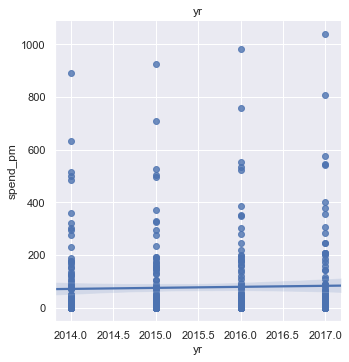

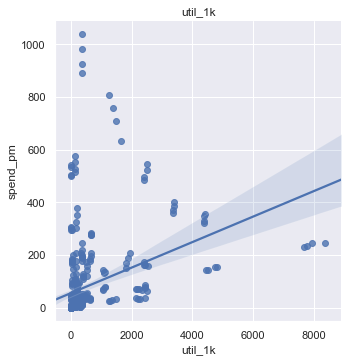

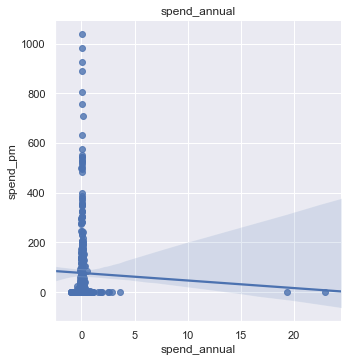

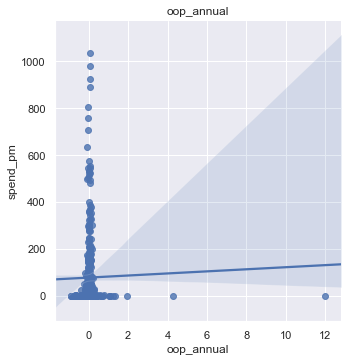

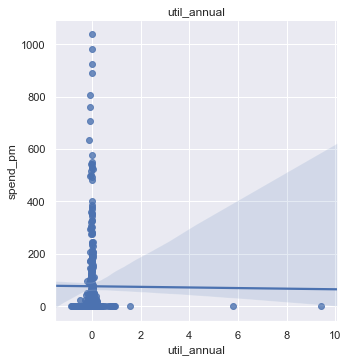

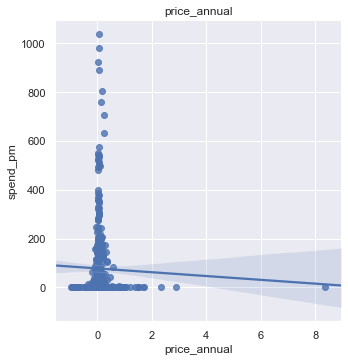

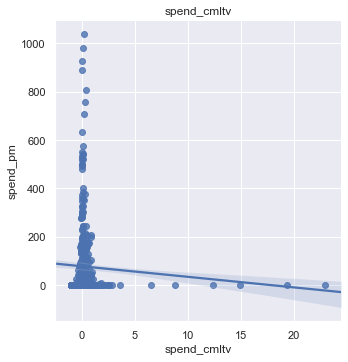

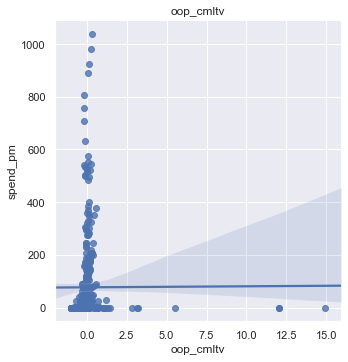

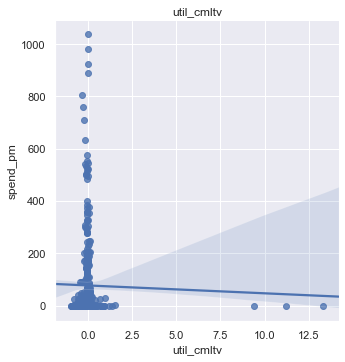

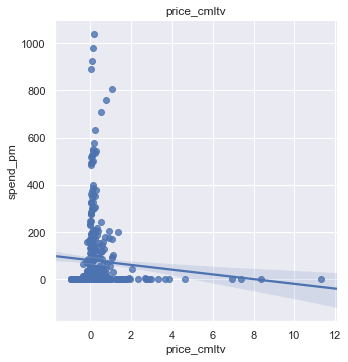

In [35]:
for i in all_cols:
    if new_df[i].dtype != 'O':
        sns.lmplot(x = i, y = 'spend_pm', data = new_df, fit_reg = True)
        plt.title(i)
        plt.show()
        sns.set(rc = {'figure.figsize':(4,4)})



## Make dummy variables

In [36]:
new_df2 = pd.get_dummies(data = new_df, columns = ['yr', 'hcci_category', 'hcci_subcategory'], prefix = ['yr', 'hcci_category', 'hcci_subcategory'], drop_first = True);
new_df2.head()

,spend_pm,util_1k,spend_annual,oop_annual,util_annual,price_annual,spend_cmltv,oop_cmltv,util_cmltv,price_cmltv,...,hcci_subcategory_RADIOLOGY,hcci_subcategory_RADIOLOGY SERVICES,hcci_subcategory_RESPIRATORY TRACT AGENTS,"hcci_subcategory_SERUMS, TOXOIDS, AND VACCINES",hcci_subcategory_SKIN AND MUCOUS MEMBRANE AGENTS,hcci_subcategory_SMOOTH MUSCLE RELAXANTS,hcci_subcategory_SNF,hcci_subcategory_Surgical,hcci_subcategory_UNGROUPABLE,hcci_subcategory_VITAMINS
1,1.820048,0.354736,-0.065075,-0.043227,-0.050844,-0.014993,-0.065075,-0.043227,-0.050844,-0.014993,...,0,0,0,0,0,0,0,0,0,0
2,1.902058,0.363465,0.045059,0.090424,0.024606,0.019962,-0.022948,0.043289,-0.027489,0.004669,...,0,0,0,0,0,0,0,0,0,0
3,1.784847,0.359615,-0.061623,0.038984,-0.010593,-0.051577,-0.083157,0.083960,-0.037790,-0.047149,...,0,0,0,0,0,0,0,0,0,0
4,1.539407,0.332171,-0.137513,-0.259388,-0.076315,-0.066254,-0.209235,-0.197206,-0.111222,-0.110279,...,0,0,0,0,0,0,0,0,0,0
6,165.636063,18.925375,0.049349,0.067026,-0.001919,0.051367,0.049349,0.067026,-0.001919,0.051367,...,0,0,0,0,0,0,0,0,0,0


## Clean column names to be acceptable for initial linear regression model

In [37]:
no_space = []
for i in list(new_df2.columns):
    no_space.append("_".join(i.split()))

no_carr = []
for i in no_space:
    no_carr.append("_".join(i.split("^")))
no_carr

no_dash = []
for i in no_carr:
    no_dash.append("_".join(i.split("-")))
no_dash

no_commas = []
for i in no_dash:
    no_commas.append("_".join(i.split(",")))
no_commas

no_slashes = []
for i in no_commas:
    no_slashes.append("_".join(i.split("/")))
no_slashes

no_op_p = []
for i in no_slashes:
    no_op_p.append("_".join(i.split("(")))
no_op_p

no_cl_p = []
for i in no_op_p:
    no_cl_p.append("_".join(i.split(")")))
no_cl_p

no_and = []
for i in no_cl_p:
    no_and.append("_".join(i.split("&")))
no_and

['spend_pm',
 'util_1k',
 'spend_annual',
 'oop_annual',
 'util_annual',
 'price_annual',
 'spend_cmltv',
 'oop_cmltv',
 'util_cmltv',
 'price_cmltv',
 'yr_2015',
 'yr_2016',
 'yr_2017',
 'hcci_category_OP',
 'hcci_category_PH',
 'hcci_category_RX',
 'hcci_subcategory_ADMINISTRATION_OF_DRUGS',
 'hcci_subcategory_AMBULANCE',
 'hcci_subcategory_ANESTHESIA',
 'hcci_subcategory_ANTI_INFECTIVE_AGENTS',
 'hcci_subcategory_ANTIHISTAMINE_DRUGS',
 'hcci_subcategory_ANTINEOPLASTIC_AGENTS',
 'hcci_subcategory_AUTONOMIC_DRUGS',
 'hcci_subcategory_All_Outpatient_Procedures',
 'hcci_subcategory_All_Outpatient_Visits',
 'hcci_subcategory_All_Prescription_Drugs',
 'hcci_subcategory_BLOOD_FORMATION__COAGULATION__AND_THROMBOSIS_AGENTS',
 'hcci_subcategory_CARDIOVASCULAR_DRUGS',
 'hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS',
 'hcci_subcategory_DEVICES',
 'hcci_subcategory_DIAGNOSTIC_AGENTS',
 'hcci_subcategory_DME_PROSTHETICS_SUPPLIES',
 'hcci_subcategory_ELECTROLYTIC__CALORIC__AND_WATER_BALANCE',
 '

In [38]:
swap_these = dict(zip(new_df2.columns, no_and))
new_df2.rename(mapper = swap_these, inplace = True, copy = False, axis = 1)

In [218]:
no_and.remove('spend_pm')
ind_vars2 = '+'.join(no_and) # with dummies for year/hcci categories/subcategories
dep_var = 'spend_pm'
ind_vars2;

# Initial linear regression model 

In [215]:
baseline_model = ols(formula = dep_var+'~'+'util_1k', data = new_df2).fit()

In [216]:
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spend_pm   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     61.38
Date:                Wed, 26 Feb 2020   Prob (F-statistic):           3.40e-14
Time:                        13:31:37   Log-Likelihood:                -2897.0
No. Observations:                 454   AIC:                             5798.
Df Residuals:                     452   BIC:                             5806.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.2550      7.270      7.601      0.000      40.968      69.542
util_1k        0.0484      0.006      7.834      0.000       0.036       0.061
==============================================================================
Omnibus:                      376.751   Durbin-Watson:                   0.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5874.918
Skew:                           3.660   Prob(JB):                         0.00
Kurtosis:                      19.031   Cond. No.                     1.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Adding in every independent variable | R^2 = 0.871, Adj R^2 = 0.851

In [40]:
reg_this = ols(formula = dep_var+'~'+ind_vars2, data = new_df2).fit()

In [41]:
reg_this.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spend_pm   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     43.47
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          4.68e-140
Time:                        17:43:16   Log-Likelihood:                -2460.7
No. Observations:                 454   AIC:                             5045.
Df Residuals:                     392   BIC:                             5301.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              433.6371     51.262      8.459      0.000     332.854     534.420
util_1k                                                                  0.0063      0.004      1.458      0.146      -0.002       0.015
spend_annual                                                             0.9343      8.440      0.111      0.912     -15.660      17.528
oop_annual                                                              29.2202     18.407      1.587      0.113      -6.969      65.410
util_annual                                                            -16.6094     21.473     -0.773      0.440     -58.827      25.608
price_annual                                                             7.9930     14.659      0.545      0.586     -20.827      36.813
spend_cmltv                                                            -10.8103      6.442     -1.678      0.094     -23.476       1.855
oop_cmltv                                                               23.7825     12.064      1.971      0.049       0.064      47.501
util_cmltv                                                             -25.2525     14.220     -1.776      0.077     -53.209       2.704
price_cmltv                                                             17.4766      8.506      2.055      0.041       0.754      34.199
yr_2015                                                                  3.5512      8.161      0.435      0.664     -12.494      19.597
yr_2016                                                                  8.1526      8.396      0.971      0.332      -8.353      24.659
yr_2017                                                                  9.7376      8.548      1.139      0.255      -7.067      26.542
hcci_category_OP                                                      -141.3448     47.203     -2.994      0.003    -234.148     -48.542
hcci_category_PH                                                      -245.7439     41.713     -5.891      0.000    -327.752    -163.735
hcci_category_RX                                                      -391.3831     48.911     -8.002      0.000    -487.543    -295.223
hcci_subcategory_ADMINISTRATION_OF_DRUGS                              -167.7503     41.651     -4.028      0.000    -249.637     -85.864
hcci_subcategory_AMBULANCE                                            -271.2159     28.359     -9.564      0.000    -326.970    -215.462
hcci_subcategory_ANESTHESIA                                            -88.8129     41.705     -2.130      0.034    -170.806      -6.820
hcci_subcategory_ANTI_INFECTIVE_AGENTS                               

# Train test split

## Split data

In [42]:
X_train, X_test, y_train, y_test = train_test_split(new_df2[no_and], new_df2['spend_pm'], test_size = 0.2, random_state = 10)


# Scale training data

## Scale fit by training data

In [43]:
scaler = StandardScaler()
scaler.fit(X = X_train) # all except ind. var 
transf_xtrain = scaler.transform(X_train)
xtrain = pd.DataFrame(transf_xtrain, columns = X_train.columns)
xtrain.head()

,util_1k,spend_annual,oop_annual,util_annual,price_annual,spend_cmltv,oop_cmltv,util_cmltv,price_cmltv,yr_2015,...,hcci_subcategory_RADIOLOGY,hcci_subcategory_RADIOLOGY_SERVICES,hcci_subcategory_RESPIRATORY_TRACT_AGENTS,hcci_subcategory_SERUMS__TOXOIDS__AND_VACCINES,hcci_subcategory_SKIN_AND_MUCOUS_MEMBRANE_AGENTS,hcci_subcategory_SMOOTH_MUSCLE_RELAXANTS,hcci_subcategory_SNF,hcci_subcategory_Surgical,hcci_subcategory_UNGROUPABLE,hcci_subcategory_VITAMINS
0,0.627590,-0.112058,0.013954,-0.002192,-0.206906,-0.186406,0.042990,-0.031816,-0.315139,1.716290,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
1,-0.316218,-0.075269,0.039270,0.005865,-0.110086,-0.147786,-0.003841,-0.046497,-0.226508,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
2,-0.433503,-0.431072,-0.631357,-0.620152,-0.607080,-0.533110,-0.530177,-0.410352,-0.754839,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
3,-0.016505,-0.136239,-0.156134,-0.027200,-0.250005,-0.270324,-0.220924,-0.033392,-0.470217,1.716290,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
4,-0.416167,-0.103571,-0.070909,-0.117789,-0.044340,-0.189584,-0.089423,-0.078337,-0.270632,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286


## Concatenate scaled x with unscaled y training data

In [44]:
y_train.reset_index(drop = True, inplace = True)
xy_train = pd.concat([y_train, xtrain], axis = 1)
xy_train

,spend_pm,util_1k,spend_annual,oop_annual,util_annual,price_annual,spend_cmltv,oop_cmltv,util_cmltv,price_cmltv,...,hcci_subcategory_RADIOLOGY,hcci_subcategory_RADIOLOGY_SERVICES,hcci_subcategory_RESPIRATORY_TRACT_AGENTS,hcci_subcategory_SERUMS__TOXOIDS__AND_VACCINES,hcci_subcategory_SKIN_AND_MUCOUS_MEMBRANE_AGENTS,hcci_subcategory_SMOOTH_MUSCLE_RELAXANTS,hcci_subcategory_SNF,hcci_subcategory_Surgical,hcci_subcategory_UNGROUPABLE,hcci_subcategory_VITAMINS
0,68.293839,0.627590,-0.112058,0.013954,-0.002192,-0.206906,-0.186406,0.042990,-0.031816,-0.315139,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
1,552.088684,-0.316218,-0.075269,0.039270,0.005865,-0.110086,-0.147786,-0.003841,-0.046497,-0.226508,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
2,0.000262,-0.433503,-0.431072,-0.631357,-0.620152,-0.607080,-0.533110,-0.530177,-0.410352,-0.754839,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
3,35.079205,-0.016505,-0.136239,-0.156134,-0.027200,-0.250005,-0.270324,-0.220924,-0.033392,-0.470217,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
4,296.460083,-0.416167,-0.103571,-0.070909,-0.117789,-0.044340,-0.189584,-0.089423,-0.078337,-0.270632,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,200.017822,-0.383539,-0.005101,0.170190,0.021825,0.071163,0.264820,0.237949,-0.185785,0.891888,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
359,24.781752,-0.382182,-0.088256,-0.111948,-0.210075,0.133237,-0.311883,-0.357928,-0.470498,0.114106,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
360,307.582031,-0.418029,-0.090883,-0.025807,-0.060790,-0.077035,-0.170972,-0.120692,-0.169928,-0.112349,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
361,0.200681,-0.433298,-0.406242,-0.734653,-0.746510,-0.273193,-0.317163,-0.359236,-0.351294,-0.180588,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286


# Feature Selection - Wrapper method, forward selection

### "Statistical Test #1 - Calculating p-values for each variable to determine which to add

In [45]:
new_cols = list(xy_train.columns)
new_cols.remove('spend_pm')
ind_var = 'spend_pm'
keep_these = []
j = 0

while j < 20: # number of independent variables to keep
    track_dict = dict.fromkeys(new_cols, 0.0)
    for i in new_cols:
        curr_join_str = '+'.join(keep_these)
        track_dict[i] = ols(formula = ind_var+'~'+curr_join_str+'+'+i, data = xy_train).fit().pvalues[-1]
    min_key = min(track_dict, key = track_dict.get)
    keep_these.append(min_key)
    new_cols.remove(min_key)
    curr_join_str = '+'.join(keep_these)
    j += 1
    
keep_these

['hcci_subcategory_All_Outpatient_Visits',
 'hcci_category_RX',
 'hcci_subcategory_All_Prescription_Drugs',
 'hcci_subcategory_All_Outpatient_Procedures',
 'hcci_subcategory_Surgical',
 'hcci_subcategory_OUTPATIENT_SURGERY',
 'util_1k',
 'hcci_subcategory_EMERGENCY_ROOM',
 'hcci_subcategory_Medical',
 'hcci_subcategory_MISCELLANEOUS_THERAPEUTIC_AGENTS',
 'hcci_subcategory_Office_Visits',
 'hcci_subcategory_Other_Services',
 'hcci_subcategory_HORMONES_AND_SYNTHETIC_SUBSTITUTES',
 'hcci_subcategory_RADIOLOGY_SERVICES',
 'hcci_subcategory_Other_Outpatient',
 'hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS',
 'hcci_subcategory_Labor_Delivery_Newborns',
 'hcci_subcategory_ANTI_INFECTIVE_AGENTS',
 'hcci_subcategory_RADIOLOGY',
 'yr_2017']

## View adjusted R^2 after adding each of the selected features

In [46]:
track_list = []
for i in range(1,21):
    dep_vars = '+'.join(keep_these[0:i])
    track_list.append(ols(formula = 'spend_pm~'+dep_vars, data = xy_train).fit().rsquared_adj)

## Linear regression with selected features | R^2 = 0.849, Adj R^2 = 0.840

In [47]:
ols(formula = f"spend_pm~{'+'.join(keep_these)}", data = xy_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spend_pm   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     96.34
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.13e-127
Time:                        17:43:55   Log-Likelihood:                -2020.0
No. Observations:                 363   AIC:                             4082.
Df Residuals:                     342   BIC:                             4164.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              81.1849      3.416     23.765      0.000      74.466      87.904
hcci_subcategory_All_Outpatient_Visits                 94.1310      3.544     26.560      0.000      87.160     101.102
hcci_category_RX                                      -18.4795      4.627     -3.993      0.000     -27.581      -9.378
hcci_subcategory_All_Prescription_Drugs                53.3501      3.819     13.969      0.000      45.838      60.862
hcci_subcategory_All_Outpatient_Procedures             44.5104      3.657     12.172      0.000      37.318      51.703
hcci_subcategory_Surgical                              49.6784      3.642     13.640      0.000      42.515      56.842
hcci_subcategory_OUTPATIENT_SURGERY                    44.7021      3.517     12.712      0.000      37.785      51.619
util_1k                                                13.2886      4.642      2.863      0.004       4.158      22.419
hcci_subcategory_EMERGENCY_ROOM                        26.8645      3.515      7.643      0.000      19.951      33.778
hcci_subcategory_Medical                               25.9118      3.553      7.293      0.000      18.923      32.901
hcci_subcategory_MISCELLANEOUS_THERAPEUTIC_AGENTS      16.2433      3.459      4.696      0.000       9.440      23.047
hcci_subcategory_Office_Visits                         21.1357      3.614      5.849      0.000      14.028      28.243
hcci_subcategory_Other_Services                        23.8245      3.993      5.966      0.000      15.970      31.679
hcci_subcategory_HORMONES_AND_SYNTHETIC_SUBSTITUTES    15.0413      3.537      4.252      0.000       8.083      21.999
hcci_subcategory_RADIOLOGY_SERVICES                    12.6686      3.521      3.598      0.000       5.744      19.594
hcci_subcategory_Other_Outpatient                      11.6942      3.519      3.323      0.001       4.772      18.616
hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS         10.0643      3.556      2.831      0.005       3.071      17.058
hcci_subcategory_Labor_Delivery_Newborns                8.8738      3.491      2.542      0.011       2.007      15.741
hcci_subcategory_ANTI_INFECTIVE_AGENTS                  7.5619      3.453      2.190      0.029       0.770      14.354
hcci_subcategory_RADIOLOGY                              6.3973      3.525      1.815      0.070      -0.537      13.331
yr_2017                                                 5.4316      3.460      1.570      0.117      -1.373      12.237
==============================================================================
Omnibus:                      133.220   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarqu

## Keep the features that are statistically independent

### Statistical test #2 - Calculate the pvalues of the selected 20 features and remove the ones that are greater than 0.05 because those are possibly linearly dependent

In [48]:
pvaluestuff = ols(formula = f"spend_pm~{'+'.join(keep_these)}", data = xy_train).fit().pvalues > 0.05

In [49]:
pvaluestuff = pvaluestuff[pvaluestuff == False]

In [50]:
joinbypvalue = "+".join(pvaluestuff.index[1:])
ols(formula = f"spend_pm~{joinbypvalue}", data = xy_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               spend_pm   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     105.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          4.22e-128
Time:                        17:43:55   Log-Likelihood:                -2022.9
No. Observations:                 363   AIC:                             4084.
Df Residuals:                     344   BIC:                             4158.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              81.1849      3.433     23.648      0.000      74.433      87.937
hcci_subcategory_All_Outpatient_Visits                 93.6087      3.553     26.349      0.000      86.621     100.596
hcci_category_RX                                      -20.6672      4.536     -4.557      0.000     -29.588     -11.746
hcci_subcategory_All_Prescription_Drugs                53.0424      3.836     13.828      0.000      45.498      60.587
hcci_subcategory_All_Outpatient_Procedures             43.9550      3.662     12.003      0.000      36.752      51.158
hcci_subcategory_Surgical                              48.8044      3.640     13.407      0.000      41.645      55.964
hcci_subcategory_OUTPATIENT_SURGERY                    44.3485      3.528     12.570      0.000      37.409      51.288
util_1k                                                13.4401      4.651      2.890      0.004       4.292      22.588
hcci_subcategory_EMERGENCY_ROOM                        26.5100      3.527      7.517      0.000      19.574      33.446
hcci_subcategory_Medical                               25.3950      3.562      7.129      0.000      18.388      32.402
hcci_subcategory_MISCELLANEOUS_THERAPEUTIC_AGENTS      16.3582      3.475      4.707      0.000       9.523      23.194
hcci_subcategory_Office_Visits                         20.4960      3.621      5.661      0.000      13.375      27.617
hcci_subcategory_Other_Services                        23.2386      3.997      5.815      0.000      15.378      31.099
hcci_subcategory_HORMONES_AND_SYNTHETIC_SUBSTITUTES    15.1306      3.553      4.258      0.000       8.142      22.119
hcci_subcategory_RADIOLOGY_SERVICES                    11.9276      3.523      3.385      0.001       4.998      18.858
hcci_subcategory_Other_Outpatient                      10.9496      3.522      3.109      0.002       4.022      17.877
hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS          9.8347      3.572      2.754      0.006       2.810      16.860
hcci_subcategory_Labor_Delivery_Newborns                8.2719      3.499      2.364      0.019       1.390      15.153
hcci_subcategory_ANTI_INFECTIVE_AGENTS                  7.5837      3.470      2.185      0.030       0.758      14.409
==============================================================================
Omnibus:                      135.157   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4917.739
Skew:                           0.827   Prob(JB):                         0.00
Kurtosis:                      20.956   Cond. No.                         2.39
================================================

# Calculations

## Created regression objects and hyperparameter list

In [51]:
ridge = Ridge()
lasso = Lasso()
lin_reg = LinearRegression()
alphas = dict(alpha = [0.01, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 15, 20])

## Find best alphas out of specified ones

In [56]:
ridge_grid = GridSearchCV(estimator = ridge, param_grid = alphas, scoring = 'neg_mean_squared_error', cv = 10)
lasso_grid = GridSearchCV(estimator = lasso, param_grid = alphas, scoring = 'neg_mean_squared_error', cv = 10)


## Fit GridSearchCV with training data to get value for hyperparameter of the training data

In [68]:
ridge_grid.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])
lasso_grid.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])
lin_reg.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])


/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/flatironschool/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
print(ridge_grid.best_params_)
print(lasso_grid.best_params_)


{'alpha': 10}
{'alpha': 0.1}


In [70]:
ridge = Ridge(ridge_grid.best_params_['alpha'])
lasso = Lasso(lasso_grid.best_params_['alpha'])

## Fit Ridge & Lasso & Linear Reg now that we have "optimal" hyperparameter

In [72]:
ridge.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])
lasso.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])
lin_reg.fit(X = xy_train[pvaluestuff.index[1:]], y = xy_train['spend_pm'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Run test set

## Cleaning the data

In [73]:
X_test # preview; dummy variables were already created

,util_1k,spend_annual,oop_annual,util_annual,price_annual,spend_cmltv,oop_cmltv,util_cmltv,price_cmltv,yr_2015,...,hcci_subcategory_RADIOLOGY,hcci_subcategory_RADIOLOGY_SERVICES,hcci_subcategory_RESPIRATORY_TRACT_AGENTS,hcci_subcategory_SERUMS__TOXOIDS__AND_VACCINES,hcci_subcategory_SKIN_AND_MUCOUS_MEMBRANE_AGENTS,hcci_subcategory_SMOOTH_MUSCLE_RELAXANTS,hcci_subcategory_SNF,hcci_subcategory_Surgical,hcci_subcategory_UNGROUPABLE,hcci_subcategory_VITAMINS
283,209.420140,0.015968,-0.018235,-0.049383,0.068746,-0.126479,-0.275852,-0.365623,0.376975,0,...,0,0,0,0,0,0,0,0,0,0
164,35.168613,-0.069772,-0.133445,-0.029433,-0.041562,-0.227172,-0.261309,0.068485,-0.276707,0,...,0,0,0,0,0,0,0,0,0,0
146,48.048447,0.504056,0.077775,-0.044933,0.574816,0.504056,0.077775,-0.044933,0.574816,0,...,0,0,0,0,0,0,0,0,0,0
385,183.976090,-0.107758,-0.129315,-0.206910,0.125019,-0.121143,-0.093415,-0.170099,0.058991,1,...,0,0,0,0,0,0,0,0,0,0
82,116.236430,0.020102,0.019067,-0.007672,0.027988,0.036337,0.029227,-0.042765,0.082635,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,3375.078900,0.015475,0.014806,-0.024371,0.040841,0.015475,0.014806,-0.024371,0.040841,0,...,0,0,0,0,0,0,0,0,0,0
189,5.011936,0.152903,-0.046413,0.050021,0.097980,0.864124,0.037387,0.153899,0.615500,0,...,0,0,0,0,0,0,0,0,0,0
102,195.224030,0.083643,0.157897,0.026826,0.055332,0.166600,0.378308,0.039342,0.122440,1,...,0,0,0,0,0,0,0,0,0,0
71,178.459430,0.093562,0.155341,0.014876,0.077532,0.093562,0.155341,0.014876,0.077532,0,...,0,0,0,0,0,0,0,0,0,0


## Scale test data

In [74]:
transf_xtest = scaler.transform(X_test) # scaler was already fit using training data -> scale test data
xtest = pd.DataFrame(transf_xtest, columns = X_test.columns)
xtest.head()

,util_1k,spend_annual,oop_annual,util_annual,price_annual,spend_cmltv,oop_cmltv,util_cmltv,price_cmltv,yr_2015,...,hcci_subcategory_RADIOLOGY,hcci_subcategory_RADIOLOGY_SERVICES,hcci_subcategory_RESPIRATORY_TRACT_AGENTS,hcci_subcategory_SERUMS__TOXOIDS__AND_VACCINES,hcci_subcategory_SKIN_AND_MUCOUS_MEMBRANE_AGENTS,hcci_subcategory_SMOOTH_MUSCLE_RELAXANTS,hcci_subcategory_SNF,hcci_subcategory_Surgical,hcci_subcategory_UNGROUPABLE,hcci_subcategory_VITAMINS
0,-0.224142,-0.095837,-0.038862,-0.087322,-0.059223,-0.253753,-0.269606,-0.350410,0.000811,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
1,-0.398352,-0.148147,-0.195914,-0.055665,-0.254162,-0.303544,-0.258413,0.047210,-0.591028,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
2,-0.385475,0.201944,0.092015,-0.080260,0.835115,0.058033,0.002565,-0.056674,0.179935,-0.582652,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
3,-0.249580,-0.171322,-0.190284,-0.337285,0.040224,-0.251115,-0.129191,-0.171320,-0.287089,1.716290,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286
4,-0.317304,-0.093315,0.011987,-0.021134,-0.131251,-0.173244,-0.034799,-0.054689,-0.265682,1.716290,...,-0.091287,-0.091287,-0.207614,-0.159448,-0.192725,-0.192725,-0.105556,-0.140225,-0.074432,-0.200286


## Concatenate scaled x with unscaled y test data

In [75]:
y_test.reset_index(drop = True, inplace = True)
xy_test = pd.concat([y_test, xtest], axis = 1) # keep y unscaled, scale x

In [76]:
list(pvaluestuff.index[1:]) # preview features we will use again; first variable is intercept so we leave that out


['hcci_subcategory_All_Outpatient_Visits',
 'hcci_category_RX',
 'hcci_subcategory_All_Prescription_Drugs',
 'hcci_subcategory_All_Outpatient_Procedures',
 'hcci_subcategory_Surgical',
 'hcci_subcategory_OUTPATIENT_SURGERY',
 'util_1k',
 'hcci_subcategory_EMERGENCY_ROOM',
 'hcci_subcategory_Medical',
 'hcci_subcategory_MISCELLANEOUS_THERAPEUTIC_AGENTS',
 'hcci_subcategory_Office_Visits',
 'hcci_subcategory_Other_Services',
 'hcci_subcategory_HORMONES_AND_SYNTHETIC_SUBSTITUTES',
 'hcci_subcategory_RADIOLOGY_SERVICES',
 'hcci_subcategory_Other_Outpatient',
 'hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS',
 'hcci_subcategory_Labor_Delivery_Newborns',
 'hcci_subcategory_ANTI_INFECTIVE_AGENTS']

## Predict values for each regression model

In [77]:
Y_ridge_test = ridge.predict(X = xy_test[pvaluestuff.index[1:]])
Y_lasso_test = lasso.predict(X = xy_test[pvaluestuff.index[1:]])
Y_linreg_test = lin_reg.predict(X = xy_test[pvaluestuff.index[1:]])

# Compare each model by their MSE

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

## View MSE

In [79]:
ridge_mse = mean_squared_error(y_true = xy_test['spend_pm'], y_pred = Y_ridge_test)
lasso_mse = mean_squared_error(y_true = xy_test['spend_pm'], y_pred = Y_lasso_test)
linreg_mse = mean_squared_error(y_true = xy_test['spend_pm'], y_pred = Y_linreg_test)

In [174]:
print(pd.DataFrame(dict(Ridge = ridge_mse, Lasso = lasso_mse, Linear_Regression = linreg_mse), index = ['MSE']))

           Ridge        Lasso  Linear_Regression
MSE  3485.998564  3636.997984        3651.004044


## View RMSE

In [175]:
print(pd.DataFrame(dict(Ridge = np.sqrt(ridge_mse), Lasso = np.sqrt(lasso_mse), Linear_Regression = np.sqrt(linreg_mse)), index = ['RMSE']))

          Ridge      Lasso  Linear_Regression
RMSE  59.042346  60.307528          60.423539


## View MAE

In [81]:
ridge_mae = mean_absolute_error(y_true = xy_test['spend_pm'], y_pred = Y_ridge_test)
lasso_mae = mean_absolute_error(y_true = xy_test['spend_pm'], y_pred = Y_lasso_test)
linreg_mae = mean_absolute_error(y_true = xy_test['spend_pm'], y_pred = Y_linreg_test)

In [82]:
print(pd.DataFrame(dict(Ridge = ridge_mae, Lasso = lasso_mae, Linear_Regression = linreg_mae), index = ['MAE']))

         Ridge      Lasso  Linear_Regression
MAE  31.741429  32.030737          31.993994


###     Ridge model performs the best

## View actual vs. predicted prices

In [83]:
results = pd.concat([xy_test['spend_pm'], pd.Series(Y_ridge_test)], axis = 1)
results.rename(mapper = {'spend_pm': 'actual', 0:'predicted'}, inplace = True, axis = 1)
results[0:30]

,actual,predicted
0,91.002686,61.780393
1,0.779492,9.979778
2,83.677727,50.195861
3,6.232134,12.153153
4,525.958557,535.155439
5,108.009949,63.267678
6,0.570508,9.475882
7,62.350903,46.143409
8,0.950741,83.947081
9,1.558512,9.468593


# Analyzing resulting data - Viewing distribution of residuals

## Preview dependent variable range & distribution

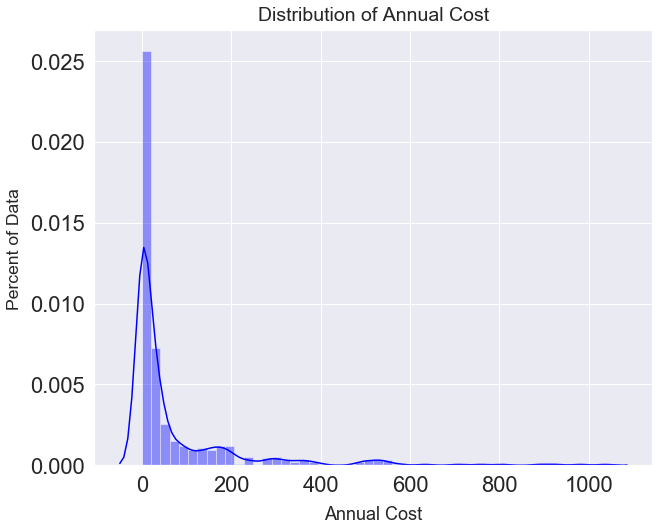

In [219]:
sns.set(font_scale = 2, rc = {'figure.figsize':(10, 8)})
dist_of_cost = sns.distplot(a = new_df['spend_pm'], color = "blue")
#, bins = 50)
dist_of_cost.set_title('Distribution of Annual Cost', fontsize = 19.5, pad = 10) # title info
dist_of_cost.set_xlabel('Annual Cost', fontsize = 18, labelpad = 10) # xlabel info
dist_of_cost.set_ylabel('Percent of Data', fontsize = 17.5, labelpad = 8) # ylabel info
# dist_of_cost.savefig("output.png")
fig = dist_of_cost.get_figure()
fig.savefig("distribution_of_annual_cost.png") 

## In a histogram

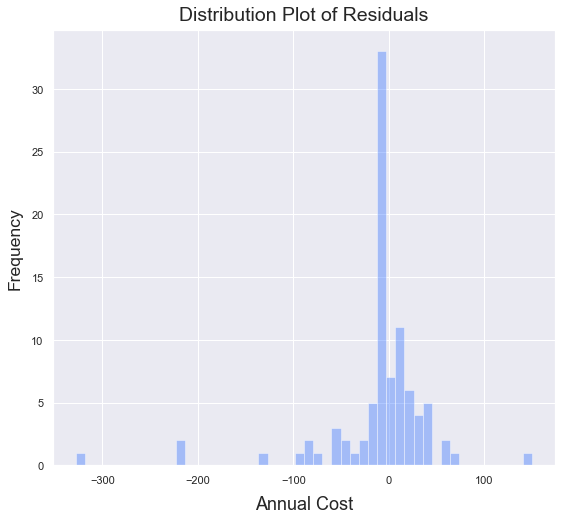

In [166]:
resid_dist = sns.distplot((results['actual'] - results['predicted']), bins = 50, kde = False, color = '#3A76FF')

resid_dist.axes.set_title('Distribution Plot of Residuals', fontsize = 19.5, pad = 10) # title info
resid_dist.set_xlabel('Annual Cost', fontsize = 18, labelpad = 10) # xlabel info
resid_dist.set_ylabel('Frequency', fontsize = 17.5, labelpad = 9) # ylabel info

sns.set(rc = {'figure.figsize':(9,8)}) # change graph size

## In a qq plot

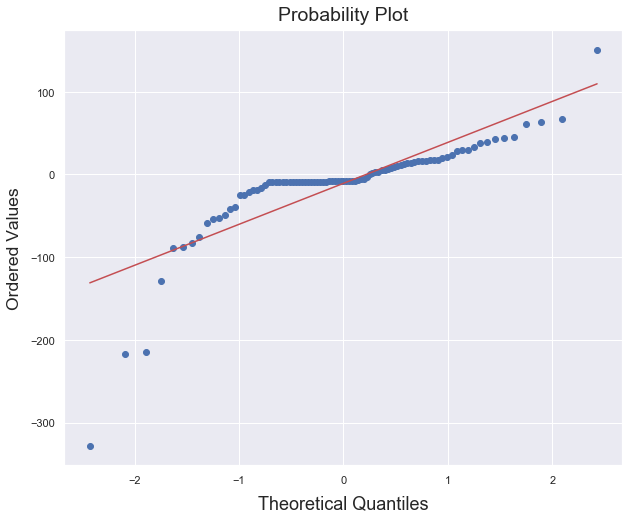

In [159]:
fig = plt.figure()
ax1 = fig.add_subplot()
qqplot = stats.probplot(x = (results['actual'] - results['predicted']), plot = ax1)

plt.title(label = 'Probability Plot', fontsize = 19.5, pad = 10) # title info
plt.xlabel(xlabel = 'Theoretical Quantiles', fontsize = 18, labelpad = 10) # xlabel info
plt.ylabel(ylabel = 'Ordered Values', fontsize = 17.5, labelpad = 8) # ylabel info
sns.set(rc = {'figure.figsize':(10,8)}) # change graph size

plt.show()


## Jarque Bera Test - Test normality of residuals

### Statistical Test #3

In [164]:
jarque_bera_stats = sms.stattools.jarque_bera((results['actual'] - results['predicted']), axis=0)
list(jarque_bera_stats)
pd.DataFrame(dict(zip(['Test Statistic', 'p_value', 'skewness', 'kurtosis'], list(jarque_bera_stats))), index = ['Values:'])

# p-value < 0.05 tells us that our data isn't normally distributed

,Test Statistic,p_value,skewness,kurtosis
Values:,587.588654,2.551202e-128,-2.584943,14.324342


## View scatter plot with regression line of most contributive continuous variable

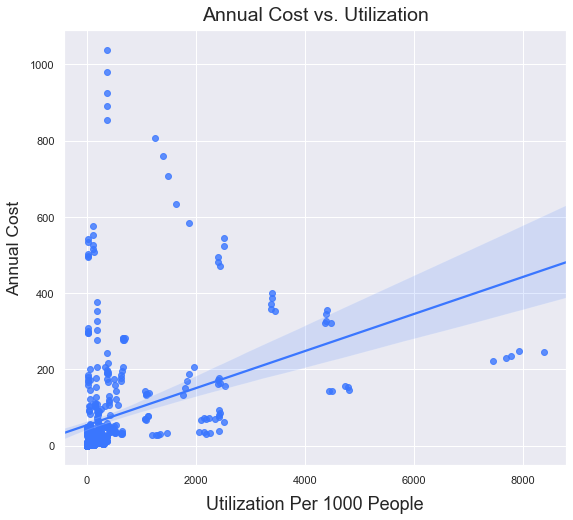

In [186]:
use_spent = sns.regplot(x = df['util_1k'], y = df['spend_pm'], color = '#3A76FF', ci = 95)
use_spent.axes.set_title('Annual Cost vs. Utilization', fontsize = 19.5, pad = 10) # title info
use_spent.set_xlabel('Utilization Per 1000 People', fontsize = 18, labelpad = 10) # xlabel info
use_spent.set_ylabel('Annual Cost', fontsize = 17.5, labelpad = 8) # ylabel info

sns.set(rc = {'figure.figsize':(9,8)}) # change graph size

# Save objects with pickle

In [87]:
import pickle

## Saving initial linear regression model

In [88]:
with open('initial_lin_reg_model.pickle', 'wb') as f:
    pickle.dump(reg_this, f)

In [ ]:
with open('initial_lin_reg_model.pickle', 'wb') as f:
    reg_this_here = pickle.load(f)

# Misc. studies

## Dictionary of independent variable names to coefficients

In [230]:
print(f'Intercept: {ridge.intercept_:.3f}')
print('Dictionary of independent variable names to coefficients:')
dict((zip(pvaluestuff.index[1:], ridge.coef_ )))


Intercept: 81.185
Dictionary of independent variable names to coefficients:


{'hcci_subcategory_All_Outpatient_Visits': 90.62181375904993,
 'hcci_category_RX': -22.156124458862777,
 'hcci_subcategory_All_Prescription_Drugs': 51.06381279940662,
 'hcci_subcategory_All_Outpatient_Procedures': 42.03705714887857,
 'hcci_subcategory_Surgical': 46.86779335124125,
 'hcci_subcategory_OUTPATIENT_SURGERY': 42.75779236288888,
 'util_1k': 14.60877453158453,
 'hcci_subcategory_EMERGENCY_ROOM': 25.386809016882115,
 'hcci_subcategory_Medical': 24.259084466489856,
 'hcci_subcategory_MISCELLANEOUS_THERAPEUTIC_AGENTS': 15.716579449458498,
 'hcci_subcategory_Office_Visits': 19.338446888792287,
 'hcci_subcategory_Other_Services': 21.64060542402607,
 'hcci_subcategory_HORMONES_AND_SYNTHETIC_SUBSTITUTES': 14.328162706134998,
 'hcci_subcategory_RADIOLOGY_SERVICES': 11.172981604962027,
 'hcci_subcategory_Other_Outpatient': 10.194142984249865,
 'hcci_subcategory_CENTRAL_NERVOUS_SYSTEM_AGENTS': 9.15281932925618,
 'hcci_subcategory_Labor_Delivery_Newborns': 7.723277529264845,
 'hcci_subca

## Stuff ended up not using - Polynomial Features

In [ ]:
# Polynomial features would have made 2080 features which is way too many for our small sample size
# So we did not use this
poly2 = PolynomialFeatures(degree = 2, interaction_only = False)

In [ ]:
X_train_poly = pd.DataFrame(poly2.fit_transform(X_train), columns=poly2.get_feature_names(X_train.columns))
X_train_poly.drop(columns = ['1'], inplace = True)
X_train_poly

In [ ]:
X_test_poly = pd.DataFrame(poly2.fit_transform(X_test), columns=poly2.get_feature_names(X_test.columns))
X_test_poly.drop(columns = ['1'], inplace = True)
X_test_poly

In [ ]:
## Polynomial Features

poly2 = PolynomialFeatures(degree = 2, interaction_only = False)

X_train_poly = pd.DataFrame(poly2.fit_transform(X_train), columns=poly2.get_feature_names(X_train.columns))
X_train_poly.drop(columns = ['1'], inplace = True)
X_train_poly

X_test_poly = pd.DataFrame(poly2.fit_transform(X_test), columns=poly2.get_feature_names(X_test.columns))
X_test_poly.drop(columns = ['1'], inplace = True)
X_test_poly

# Conclusion

While making and choosing our models, we tested making polynomial features out of the dependent variables. This helped when we had fewer categorical features, but when we added the treatment subcategory (hospice, radiology, etc.) in addition to the supercategory (Inpatient, Outpatient, etc.) the number of features this created was untenable. 

Using forward feature selection, we were left with 18 features, all but two were dummy variables for treatment subcategory, one was the commonality of the procedure per 1,000 people, and one treatment supercategory (RX). 

Our variables were highly correlated with annual cost except for the treatment being in the supercategory RX, which had a negative correlation. 

Our final model is a Ridge model with a lambda of 10. 

We chose the Mean Absolute Error (MAE) as our metric instead of the Root Mean Squared Error (RSME) since RSME gives more weight outliers while our data did have outliers, so we did not want to give them much weight in our metric. 

Our model had a MAE of $31, meaning that our predictions, on average, were 31 dollars off from the actual annual cost. The model does not have normally distributed residuals since the outliers made for a distribution with high kurtosis (leptokurtic).